In [5]:
import os
import pandas as pd
import numpy as np
from typing import List, Tuple, Optional

from scipy.signal import butter, sosfiltfilt, iirnotch, filtfilt


## **Load Data**

**Load Raw Data Files from Each Participant**

In [6]:
# path to folder that holds participant data
data_path = "C:/Users/nicho/Desktop/Nick-Weiss-CSC-Thesis-2526/data"

# get all the folders inside data directory that hold individual trials
participant_folders = [
    entry for entry in os.listdir(data_path) 
    if os.path.isdir(os.path.join(data_path, entry))
]

# keep list of all dataframes
dfs = []

# folder name is the participant id
# ****MIGHT CHANGE THE FORMAT OF THE FOLDER LATER --> COME BACK TO THIS****
for participant_id in participant_folders:
    # get the path to the finalized data file
    csv_path = os.path.join(
        data_path, 
        participant_id, 
        "finalized_data.csv"
    )
    
    # print error if csv not found
    if not os.path.exists(csv_path):
        print(f"Skipping Participant {participant_id}: finalized_data.csv not found in {os.path.join(data_path, participant_id)}" )
    else:
        # read csv into dataframe
        participant_df = pd.read_csv(csv_path)

        # add participant id column and append to list
        participant_df['participant_id'] = participant_id
        dfs.append(participant_df)


**Clean Dataframes to ensure proper labels**

In [7]:
def clean_participant_df(df: pd.DataFrame) -> pd.DataFrame:
    # drop rows that are entirely empty
    df = df.dropna(how="all").copy()

    # check that df includes required columns
    time_col = "Time (s)"
    label_col = "Primitive"
    required_cols = [time_col, label_col]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"{df['participant_id'].iloc[0]}: missing required column '{col}'")

    # make sure time column is numeric
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")

    # remove rows where Time (s) is NaN, orders rows by increasing time, reset df indices
    df = df.dropna(subset=[time_col]).sort_values(time_col)

    # drop duplicated time rows (keep first occurrance)
    df = df.drop_duplicates(subset=[time_col], keep="first")

    # force labels to be text and strip whitespace
    df[label_col] = df[label_col].astype("string").str.strip()

    # only keep rows that have a valid label attached
    df = df[df[label_col].notna() & (df[label_col] != "")]

    return df.reset_index(drop=True)


**Estimating Sampling Rate**

In [8]:
def estimate_fs_from_time(df: pd.DataFrame) -> float:
    time_col = "Time (s)"
    t = pd.to_numeric(df[time_col], errors="coerce").to_numpy(dtype=float)
    t = t[~np.isnan(t)]
    dt = np.diff(t)
    dt = dt[dt > 0]
    if dt.size == 0:
        raise ValueError("Cannot estimate fs: no positive time differences.")
    fs = 1.0 / np.median(dt)
    return float(fs)


**Filtering Helper Functions**

In [9]:
# handle missing values --> important so filters dont explode when they hit NaN
def col_to_float_with_small_gap_fill(series: pd.Series) -> np.ndarray:
    x = pd.to_numeric(series, errors="coerce").astype(float)
    x = x.interpolate(method="linear", limit_direction="both")
    return x.to_numpy()

# high-pass filter to remove drift
def highpass_filter(x: np.ndarray, fs: float, cutoff_hz: float = 20.0, order: int = 2) -> np.ndarray:
    nyq = 0.5 * fs
    sos = butter(order, cutoff_hz / nyq, btype="highpass", output="sos")
    # sosfiltfilt applies the filter foward and backward, giving zero phase shift (envelope timing must match video labels)
    return sosfiltfilt(sos, x)

# notch filter 60Hz and 120Hz power line interference
def notch_filter(x: np.ndarray, fs: float, freq_hz: float, q: float = 35.0) -> np.ndarray:
    nyq = 0.5 * fs
    if freq_hz >= nyq:
        return x  # can't notch above Nyquist
    w0 = freq_hz / nyq
    b, a = iirnotch(w0, q)
    return filtfilt(b, a, x)

# band pass filter (keep EMG band)
def bandpass_filter(x: np.ndarray, fs: float, low_hz: float = 20.0, high_hz: float = 450.0, order: int = 4) -> np.ndarray:
    nyq = 0.5 * fs
    high_hz = min(high_hz, 0.99 * nyq)
    sos = butter(order, [low_hz / nyq, high_hz / nyq], btype="bandpass", output="sos")
    return sosfiltfilt(sos, x)

# rectify
def rectify(x: np.ndarray) -> np.ndarray:
    return np.abs(x)

# low-pass filter
def lowpass_filter(x: np.ndarray, fs: float, cutoff_hz: float = 5.0, order: int = 4) -> np.ndarray:
    nyq = 0.5 * fs
    sos = butter(order, cutoff_hz / nyq, btype="lowpass", output="sos")
    return sosfiltfilt(sos, x)

# get emg envelope (low-pass and rectified)
def emg_envelope(x_bandpassed: np.ndarray, fs: float, envelope_lp_hz: float = 5.0) -> np.ndarray:
    x_rect = rectify(x_bandpassed)
    env = lowpass_filter(x_rect, fs=fs, cutoff_hz=envelope_lp_hz, order=4)
    return env

**EMG Feature Engineering**

In [10]:
def add_emg_features(
    df: pd.DataFrame,
    emg_columns: list[str],
    fs: float,
    hp_hz: float = 20.0,
    notch_freqs: tuple[float, ...] = (60.0, 120.0),
    bp_low_hz: float = 20.0,
    bp_high_hz: float = 450.0,
    env_lp_hz: float = 5.0,
) -> pd.DataFrame:
    out = df.copy()
    

    # want to apply feature engineering to all emg columns
    for col in emg_columns:
        if col  in out.columns:      
            # interpolate missing values
            x = col_to_float_with_small_gap_fill(out[col])

            # apply high pass filter
            x = highpass_filter(x, fs=fs, cutoff_hz=hp_hz, order=2)

            # apply notch filters
            for f0 in notch_freqs:
                x = notch_filter(x, fs=fs, freq_hz=f0, q=35.0)

            # apply bandpass filter
            x_bp = bandpass_filter(x, fs=fs, low_hz=bp_low_hz, high_hz=bp_high_hz, order=4)

            # envelope emg
            env = emg_envelope(x_bp, fs=fs, envelope_lp_hz=env_lp_hz)

            out[col] = x_bp
            out[f"{col}_ENV"] = env

    return out

**Accelerometer Feature Engineering**

In [11]:
def add_accel_features(
    df: pd.DataFrame,
    sensor_ids: list[str],
    fs: float,
    accel_lowpass_hz: float = 20.0,
    dyn_highpass_hz: float = 0.3,
) -> pd.DataFrame:
    out = df.copy()

    for sid in sensor_ids:
        ax = f"{sid}_AccelX"
        ay = f"{sid}_AccelY"
        az = f"{sid}_AccelZ"

        # skip if missing
        if not all(c in out.columns for c in [ax, ay, az]):
            continue

        # filter each axis (lowpass), then compute dynamic component (highpass)
        for col in [ax, ay, az]:
            x = col_to_float_with_small_gap_fill(out[col])

            x_lp = lowpass_filter(x, fs=fs, cutoff_hz=accel_lowpass_hz, order=4)
            x_dyn = highpass_filter(x_lp, fs=fs, cutoff_hz=dyn_highpass_hz, order=2)

            out[col] = x_lp
            out[f"{col}_DYN"] = x_dyn

        # magnitudes (use low-passed signals)
        out[f"{sid}_AccelMag"] = np.sqrt(out[ax]**2 + out[ay]**2 + out[az]**2)

        # optional: magnitude of dynamic component
        out[f"{sid}_AccelMag_DYN"] = np.sqrt(
            out[f"{ax}_DYN"]**2 + out[f"{ay}_DYN"]**2 + out[f"{az}_DYN"]**2
        )

    return out

**Gyroscope Feature Engineering**

In [12]:
def add_gyro_features(
    df: pd.DataFrame,
    sensor_ids: list[str],
    fs: float,
    gyro_lowpass_hz: float = 20.0,
) -> pd.DataFrame:
    out = df.copy()

    for sid in sensor_ids:
        gx = f"{sid}_GyroX"
        gy = f"{sid}_GyroY"
        gz = f"{sid}_GyroZ"

        # skip if missing
        if not all(c in out.columns for c in [gx, gy, gz]):
            continue

        # low-pass each axis
        for col in [gx, gy, gz]:
            x = col_to_float_with_small_gap_fill(out[col])
            x_lp = lowpass_filter(x, fs=fs, cutoff_hz=gyro_lowpass_hz, order=4)
            out[col] = x_lp

        # magnitude (use low-passed axes)
        out[f"{sid}_GyroMag"] = np.sqrt(out[gx]**2 + out[gy]**2 + out[gz]**2)

    return out

**Magnetometer Feature Engineering**

In [13]:
def add_mag_features(
    df: pd.DataFrame,
    sensor_ids: list[str],
    fs: float,
    mag_lowpass_hz: float = 10.0,
) -> pd.DataFrame:
    out = df.copy()

    for sid in sensor_ids:
        mx = f"{sid}_MagX"
        my = f"{sid}_MagY"
        mz = f"{sid}_MagZ"

        # skip if missing
        if not all(c in out.columns for c in [mx, my, mz]):
            continue

        # low-pass each axis
        for col in [mx, my, mz]:
            x = col_to_float_with_small_gap_fill(out[col])
            x_lp = lowpass_filter(x, fs=fs, cutoff_hz=mag_lowpass_hz, order=4)
            out[col] = x_lp

        # magnitude (use low-passed axes)
        out[f"{sid}_MagnetMag"] = np.sqrt(out[mx]**2 + out[my]**2 + out[mz]**2)

    return out

In [14]:
sensor_ids = ["A5F2", "A19E"]


emg_cols = []
for id in sensor_ids:
    emg_cols.append(f"{id}_EMG1")
    emg_cols.append(f"{id}_EMG2")


for i in range(len(dfs)):
    df = dfs[i]
    df = clean_participant_df(df)
    # get sampling rate
    fs = estimate_fs_from_time(df)
    df = add_emg_features(df, emg_cols, fs)
    df = add_accel_features(df, sensor_ids, fs)
    df = add_gyro_features(df, sensor_ids, fs)
    df = add_mag_features(df, sensor_ids, fs)
    dfs[i] = df

full_df = pd.concat(dfs, ignore_index=True)

**Separate Features and Labels and Split Data**

In [15]:
# separate features, labels, and groups
label_col = "Primitive"
group_col = "participant_id"

feature_cols = [
    c for c in full_df.columns
    if c not in [label_col, group_col, "Time (s)", "Event_Marker"]
]


# independence is defined at the participant level
# all samples from a participant must stay together in either train or test
# this prevents: identity leakage, movement-style memorization, sensor placement bias



In [22]:
import numpy as np
import pandas as pd

def to_float_filled(s):
    s = pd.to_numeric(s, errors="coerce").astype(float)
    s = s.interpolate(method="linear", limit_direction="both")
    return s.to_numpy()

def slope(x):
    n = x.size
    if n < 2:
        return 0.0
    i = np.arange(n, dtype=float)
    i_mean = i.mean()
    x_mean = x.mean()
    denom = np.sum((i - i_mean) ** 2)
    if denom < 1e-12:
        return 0.0
    num = np.sum((i - i_mean) * (x - x_mean))
    return float(num / denom)


def build_summary_windows_for_rf_fullres(dfs, sensor_ids, window_sec=1.0):
    """
    Full-resolution window summaries (no downsampling).

    Input:  list of per-participant dataframes (already cleaned + feature engineered)
    Output: list of per-participant summary dataframes

    For each center row t where a full centered window exists:
      - window = all rows in [t - window_sec/2, t + window_sec/2] in *row units*
        (based on estimated fs from Time (s))
      - compute summary stats over the full-res window for selected features
      - keep Primitive at center as label
    """


    # specify which features to look at
    base_features = []
    for sid in sensor_ids:
        base_features += [
            f"{sid}_EMG1_ENV",
            f"{sid}_EMG2_ENV",
            f"{sid}_AccelMag_DYN",
            f"{sid}_GyroMag",
        ]

    out_dfs = []

    for df in dfs:
        df = df.sort_values("Time (s)").reset_index(drop=True)

        # get number of rows necessary (based on fs) to fill window length
        fs = estimate_fs_from_time(df)
        half_n = int(round((window_sec / 2.0) * fs))  # in rows, since dt ~ 1/fs

        # collect feature columns
        feat_cols = [c for c in base_features if c in df.columns]
        if len(feat_cols) == 0:
            raise ValueError("No expected feature columns found (e.g., *_EMG*_ENV, *_AccelMag_DYN, *_GyroMag).")

        # convert feature columns to numpy once (all feature columns store as numpy lists now)
        feat_arrays = {c: to_float_filled(df[c]) for c in feat_cols}

        # collect times, labels, and participant ids
        times = pd.to_numeric(df["Time (s)"], errors="coerce").to_numpy(dtype=float)
        labels = df["Primitive"].astype("string").to_numpy()
        pids = df["participant_id"].astype("string").to_numpy()

        n = len(df)
        start = half_n
        end = n - half_n - 1
        if end <= start:
            out_dfs.append(pd.DataFrame())
            continue

        rows = []
        for center in range(n):
            left = max(0, center - half_n)
            right = min(n, center + half_n + 1)

            row = {
                "participant_id": pids[center],
                "center_time_s": times[center],
                "Primitive": labels[center],
                "window_len": right - left,
                "window_frac_full": (right - left) / (2*half_n + 1),
            }

            for c in feat_cols:
                w = feat_arrays[c][left:right]
                row[f"{c}__mean"] = float(np.mean(w))
                row[f"{c}__std"]  = float(np.std(w))
                row[f"{c}__min"]  = float(np.min(w))
                row[f"{c}__max"]  = float(np.max(w))
                row[f"{c}__slope"]= slope(w)
            print(times[center])
            rows.append(row)
        out_dfs.append(pd.DataFrame(rows))

    return out_dfs


In [ ]:
windows = build_summary_windows_for_rf_fullres(dfs, sensor_ids, window_sec=1)

0.0
0.0019833984375026
0.0039670410156205
0.0059506835937526
0.0079343261718776
0.0099179687500026
0.0119016113281347
0.0138852539062526
0.0158688964843705
0.0178830566406276
0.0198361816406276
0.0218195800781302
0.0238339843750026
0.0257871093750026
0.02777099609375
0.0297849121093847
0.0317685546875026
0.0337216796875026
0.0357358398437526
0.0377194824218776
0.0397031250000026
0.0416867675781347
0.0436704101562526
0.0456540527343705
0.0476376953125026
0.0496213378906276
0.0516049804687526
0.0535883789062552
0.0555722656250026
0.0575559082031276
0.0595087890625052
0.0615231933593847
0.0635068359375026
0.0654904785156205
0.0674741210937526
0.0694272460937526
0.0714108886718776
0.0733945312500026
0.0753781738281347
0.0773615722656302
0.0793759765625026
0.0813596191406276
0.08331298828125
0.0852963867187526
0.0872800292968705
0.0909421386718776
0.0932309570312526
0.0952145996093847
0.0971982421875026
0.0991818847656205
0.1011655273437526
0.1031491699218776
0.1051328125000026
0.1071164550

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def train_rf_from_summary_dfs(summary_dfs, label_col="Primitive"):
    # 1) concat + drop empties
    df_all = pd.concat([d for d in summary_dfs if d is not None and len(d) > 0], ignore_index=True)

    # 2) X/y (drop non-features)
    drop_cols = [label_col, "participant_id", "center_time_s"]
    drop_cols = [c for c in drop_cols if c in df_all.columns]

    X = df_all.drop(columns=drop_cols)
    y = df_all[label_col].astype(str).to_numpy()

    # keep only numeric feature columns (RF needs numbers)
    X = X.select_dtypes(include=[np.number])

    # 3) label encode
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    # 4) split
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    # )

    df_all = df_all.sort_values("center_time_s").reset_index(drop=True)

    cut = int(0.8 * len(df_all))
    X_train, X_test = X.iloc[:cut], X.iloc[cut:]
    y_train, y_test = y_enc[:cut], y_enc[cut:]

    # 5) model (imputer handles any leftover NaNs)
    clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            n_estimators=400,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced_subsample",
            max_features="sqrt"
        ))
    ])

    clf.fit(X_train, y_train)

    # 6) eval
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    labels = ["Idle", "Reach", "Reposition", "Stabilize", "Transport"]

    cm = confusion_matrix(y_test, y_pred, labels=range(len(labels)))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=None, values_format="d")

    plt.title("Confusion Matrix (Counts)")
    plt.tight_layout()
    plt.show()

    return clf, le, X.columns.tolist(), df_all


              precision    recall  f1-score   support

        Idle       0.58      0.95      0.72      9571
       Reach       0.81      0.31      0.45      5547
  Reposition       0.85      0.50      0.63      9034
   Stabilize       0.77      0.84      0.81     11386
   Transport       0.61      0.61      0.61      9605

    accuracy                           0.68     45143
   macro avg       0.72      0.64      0.64     45143
weighted avg       0.72      0.68      0.67     45143



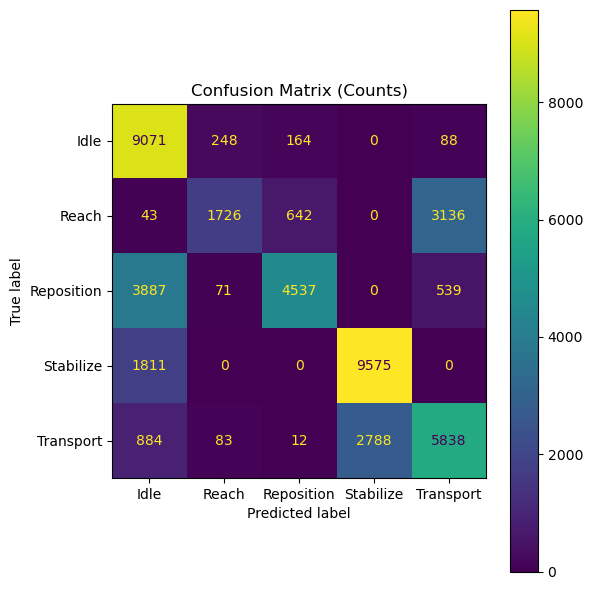

In [43]:
rf_model, label_encoder, feature_cols, df_all = train_rf_from_summary_dfs(windows)

<bound method Pipeline.score of Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=400, n_jobs=-1,
                                        random_state=42))])>
